In [ ]:
! pip install chainlit
! pip install llama-index-vector-stores-azureaisearch==0.2.8
! pip install azure-storage-blob


In [ ]:
# Initial Setup: Load environment variables and initialize services
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType
import os
import asyncio
from azure.storage.blob.aio import BlobServiceClient
from dotenv import load_dotenv
from llama_parse import LlamaParse
import nest_asyncio


# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

In [ ]:
# Phoenix can display in real time the traces automatically
# collected from your LlamaIndex application.
# Run all of your LlamaIndex applications as usual and traces
# will be collected and displayed in Phoenix.

import phoenix as px

# Look for a URL in the output to open the App in a browser.
px.launch_app()
# The App is initially empty, but as you proceed with the steps below,
# traces will appear automatically as your LlamaIndex application runs.

import llama_index.core

llama_index.core.set_global_handler("arize_phoenix")
...

In [80]:
# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "llamaindex-azure-aisearch-rag"


In [81]:
# Initialize Azure OpenAI models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)


In [ ]:


# Allow nested event loops in Jupyter Notebook
nest_asyncio.apply()

# Load environment variables
load_dotenv()

# Azure Blob Configuration
BLOB_CONNECTION_STRING = os.getenv("BLOB_CONNECTION_STRING")
BLOB_STORAGE_ACCOUNT_KEY = os.getenv("BLOB_STORAGE_ACCOUNT_KEY")
BLOB_CONTAINER_NAME = "demo-images"

# Set up download path and parser
DOWNLOAD_PATH = "data_images_state_of_ai_report_2024"
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    azure_openai_endpoint=f"{os.getenv('AZURE_OPENAI_ENDPOINT')}openai/deployments/{os.getenv('AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME')}chat/completions?api-version=2024-08-01-preview",
    azure_openai_api_version="2024-08-01-preview",
    azure_openai_key=os.getenv("AZURE_OPENAI_API_KEY"),
)

# Parse document and extract images
md_json_objs = parser.get_json_result("data/llamaparse/State of AI Report 2024.pdf")
md_json_list = md_json_objs[0]["pages"]
image_dicts = parser.get_images(md_json_objs, download_path=DOWNLOAD_PATH)

# Limit the number of concurrent uploads
CONCURRENT_UPLOADS = 5

async def upload_image_to_blob_storage(image, blob_name, semaphore):
    async with semaphore:
        try:
            image_path = image.get('path') or image.get('original_file_path')
            if not image_path or not os.path.exists(image_path):
                return None

            blob_service_client = BlobServiceClient.from_connection_string(BLOB_CONNECTION_STRING)
            async with blob_service_client:
                container_client = blob_service_client.get_container_client(BLOB_CONTAINER_NAME)
                if not await container_client.exists():
                    await container_client.create_container()

                blob_client = container_client.get_blob_client(blob_name)

                with open(image_path, "rb") as f:
                    await blob_client.upload_blob(f, overwrite=True)

                return blob_client.url

        except Exception as e:
            print(f"Failed to upload {blob_name}: {e}")
            return None

async def main():
    semaphore = asyncio.Semaphore(CONCURRENT_UPLOADS)
    upload_tasks = [upload_image_to_blob_storage(image, image["name"], semaphore) for image in image_dicts]
    results = await asyncio.gather(*upload_tasks)

    return {
        image["name"]: url
        for image, url in zip(image_dicts, results)
        if url is not None
    }

# Run the main function
image_urls = asyncio.run(main())
print(image_urls)


In [89]:
print(md_json_list[10]["md"])

# Section 1: Research


In [57]:
import re
from copy import deepcopy
from typing import Dict, List
from llama_index.core.schema import TextNode, MetadataMode

def get_page_number(file_name: str) -> int:
    """Extract page number from blob name."""
    match = re.search(r"page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_blob_urls(image_urls: Dict[str, str]) -> List[str]:
    """Get blob URLs sorted by page number."""
    # Convert the dictionary to a list of tuples (name, url) and sort by page number
    sorted_items = sorted(image_urls.items(), key=lambda x: get_page_number(x[0]))
    # Return just the URLs in sorted order
    return [url for _, url in sorted_items]

def get_text_nodes(image_urls: Dict[str, str], json_dicts: List[dict]) -> List[TextNode]:
    """Create TextNodes with metadata including blob URLs as image_path and doc_id."""
    nodes = []
    
    # Get sorted blob URLs
    sorted_urls = _get_sorted_blob_urls(image_urls)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        # Skip if we don't have a corresponding image URL
        if idx >= len(sorted_urls):
            continue
            
        doc_id = f"doc_{idx+1}"
        
        chunk_metadata = {
            "page_num": idx + 1,
            "image_path": sorted_urls[idx],  # Store blob URL as image_path
            "parsed_text_markdown": md_texts[idx],
        }

        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes

# Usage example:
text_nodes = get_text_nodes(image_urls=image_urls, json_dicts=md_json_list)

# Print an example node to verify
print(text_nodes[0].get_content(metadata_mode=MetadataMode.ALL))

page_num: 1
image_path: https://ignite2024demo.blob.core.windows.net/demo-images/page_1.jpg
parsed_text_markdown: # STATE OF AI REPORT

October 10, 2024

Nathan Benaich

**AIR STREET CAPITAL**

[stateof.ai](http://stateof.ai) | [airstreet.com](http://airstreet.com)


In [59]:
from llama_index.vector_stores.azureaisearch import (
    AzureAISearchVectorStore,
    IndexManagement,
    MetadataIndexFieldType
)
from llama_index.core import VectorStoreIndex

# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

def create_vector_store(
    index_client,
    index_name: str,
    use_existing_index: bool = False
) -> AzureAISearchVectorStore:
    """Create or get existing Azure AI Search vector store."""
    return AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name=index_name,
        index_management=IndexManagement.VALIDATE_INDEX if use_existing_index 
                        else IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

def create_or_load_index(
    text_nodes,
    index_client,
    index_name: str,
    embed_model,
    llm,
    use_existing_index: bool = False
) -> VectorStoreIndex:
    """Create new index or load existing one."""
    # Create vector store
    vector_store = create_vector_store(index_client, index_name, use_existing_index)
    
    # Create storage context
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    
    if use_existing_index:
        # Load existing index
        return VectorStoreIndex.from_documents(
            [],
            storage_context=storage_context,
        )
    else:
        # Create new index with nodes
        return VectorStoreIndex(
            nodes=text_nodes,
            storage_context=storage_context,
            embed_model=embed_model,
            llm=llm,
            show_progress=True,
        )

# Usage example:
use_existing_index = False  # Set to True if you want to use existing index

# Create or load the index
index = create_or_load_index(
    text_nodes=text_nodes,
    index_client=index_client,
    index_name=INDEX_NAME,
    embed_model=embed_model,
    llm=llm,
    use_existing_index=use_existing_index
)

Generating embeddings:   0%|          | 0/212 [00:00<?, ?it/s]

In [82]:
from llama_index.core.query_engine import CustomQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from typing import Optional

# Initialize AzureOpenAIMultiModal for GPT-4o-mini
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine="gpt-4o-mini",
    api_version="2024-06-01",
    model="gpt-4o-mini",
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)

class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine for public blob storage."""

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str) -> Response:
        # Retrieve relevant nodes
        nodes = self.retriever.retrieve(query_str)
        
        # Create ImageNode items directly using the blob URLs
        image_nodes = []
        for n in nodes:
            if "image_path" in n.metadata:
                try:
                    image_nodes.append(
                        NodeWithScore(node=ImageNode(image_url=n.metadata["image_path"]))
                    )
                except Exception as e:
                    print(f"Warning: Failed to create ImageNode for {n.metadata['image_path']}: {str(e)}")
                    continue

        # Create context string from text nodes
        context_str = "\n\n".join(
            [node.get_content(metadata_mode=MetadataMode.LLM) for node in nodes]
        )
        
        # Format the prompt
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)

        # Get response from multimodal LLM
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )

        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )

Query: What impact does ColPali's use of visual structure have on improving retrieval performance in vision-language models, compared to traditional text-based embeddings?
Retrieved Images:



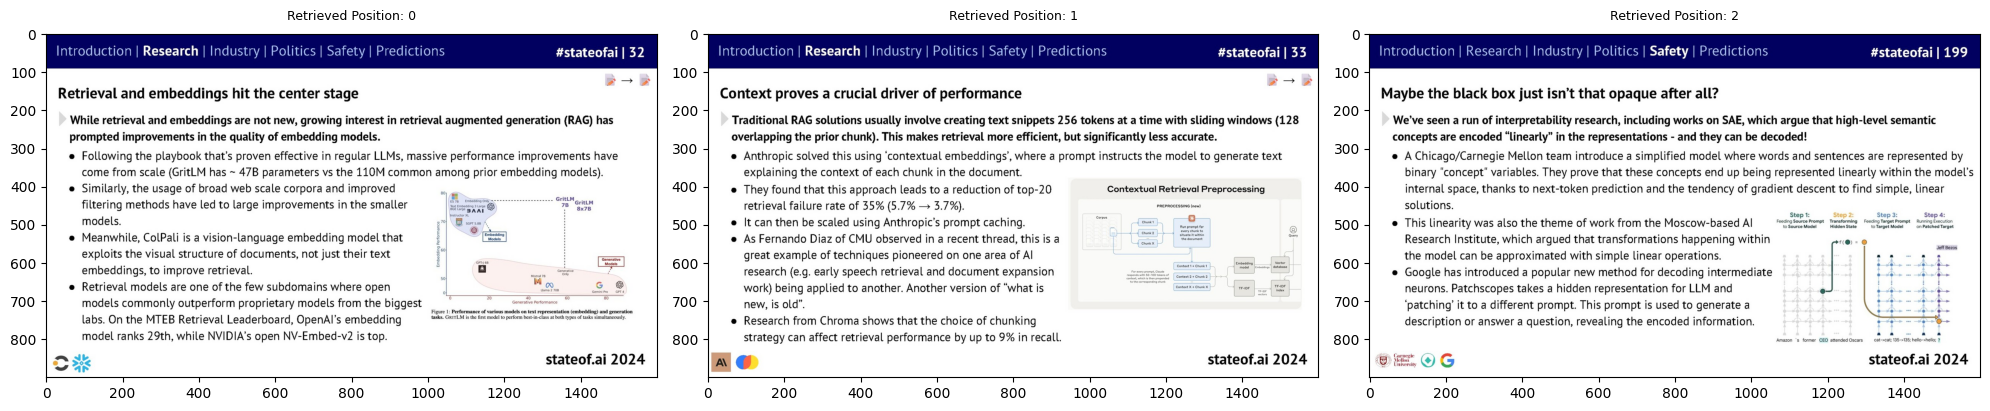

Response: The answer to the query about the impact of ColPali's use of visual structure on improving retrieval performance in vision-language models, compared to traditional text-based embeddings, is found in the parsed markdown for page 32. 

ColPali is described as a vision-language embedding model that "exploits the visual structure of documents, not just their text embeddings, to improve retrieval." This suggests that by incorporating visual elements, ColPali enhances the retrieval process beyond what traditional text-based embeddings can achieve.

The parsed markdown provides a clear explanation of ColPali's approach and its implications for retrieval performance, while the images do not contain specific details about ColPali. Therefore, the information is derived from the parsed markdown, and there are no discrepancies between the markdown and the images regarding this specific query.

Final Answer: ColPali improves retrieval performance by utilizing the visual structure of docum

In [ ]:
# Example usage of MultimodalQueryEngine
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_index.core import get_response_synthesizer

# Create the query engine 
query_engine = MultimodalQueryEngine(
    retriever=index.as_retriever(
        vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=3
    ),
    multi_modal_llm=azure_openai_mm_llm,
)

# Query with baseline retrieval
query = "What impact does ColPali's use of visual structure have on improving retrieval performance in vision-language models, compared to traditional text-based embeddings?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes
print("\nSource Nodes for standard_embedding_query_engine:")
for node in response.source_nodes:
    print(node.get_content(metadata_mode=MetadataMode.LLM))

Query: What are the key advancements of AI technologies in 2024 according to the State of AI report?
Retrieved Images:



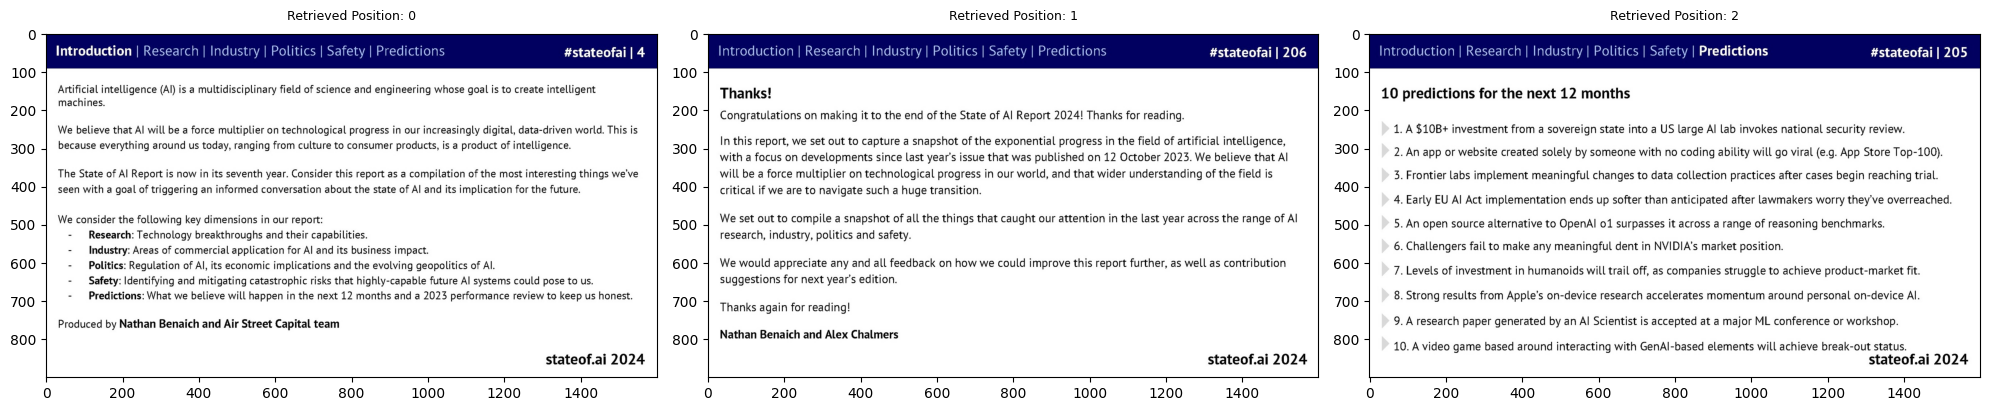

Response: The key advancements of AI technologies in 2024, according to the State of AI report, include:

1. Significant investments from sovereign states into AI labs, invoking national security reviews.
2. Viral success of applications or websites created by individuals without coding skills.
3. Changes in data collection practices by frontier labs following legal trials.
4. A softer implementation of the EU AI Act than initially anticipated.
5. An open-source alternative to OpenAI surpassing it in reasoning benchmarks.
6. Continued dominance of NVIDIA in the market despite challengers.
7. A decline in investment in humanoid technologies due to struggles with product-market fit.
8. Accelerated momentum around personal on-device AI driven by Apple's research.
9. Acceptance of a research paper generated by an AI at a major machine learning conference.
10. Breakout success of a video game featuring interactions with GenAI elements.

This information was derived from the parsed markdown 

In [88]:

# Query with baseline retrieval
query = "What are the key advancements of AI technologies in 2024 according to the State of AI report?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes
print("\nSource Nodes for standard_embedding_query_engine:")
for node in response.source_nodes:
    print(node.get_content(metadata_mode=MetadataMode.LLM))